In [ ]:
!pip install opensmile gdown --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 21.9 MB/s eta 0:00:00


### Accessing Dataset

In [ ]:
import os
import tarfile

# download tarball
!gdown 1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS

tarball_filename = "ADReSSo21-diagnosis-train.tar"

# extract all contents into the current working directory
with tarfile.open(tarball_filename, 'r:*') as tar:
    tar.extractall(path="./")

# clean up
os.remove(tarball_filename)

Downloading...
From (original): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS
From (redirected): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS&confirm=t&uuid=bcc08e8b-dae2-4709-bf9e-902db4b4874e
To: /content/ADReSSo21-diagnosis-train.tar
100% 1.75G/1.75G [00:14<00:00, 117MB/s]


### Helper Functions

In [ ]:
# disable HF & librosa progress/warnings
import os
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
from transformers import logging
logging.disable_progress_bar()
logging.set_verbosity_error()

# unique library imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa
import librosa.display
from IPython.display import Audio, display
import pandas as pd
import numpy as np
import soundfile as sf
import tempfile
import opensmile
import concurrent.futures
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from pathlib import Path
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import re


import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from tabulate import tabulate
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



# define the base dataset directory and build related paths
dataset_dir = Path('ADReSSo21/diagnosis/train')
paths = {
    'audio': dataset_dir / 'audio',
    'audio_ad': dataset_dir / 'audio' / 'ad',
    'audio_cn': dataset_dir / 'audio' / 'cn',
    'segmentation': dataset_dir / 'segmentation',
    'segmentation_ad': dataset_dir / 'segmentation' / 'ad',
    'segmentation_cn': dataset_dir / 'segmentation' / 'cn'
}

def count_files(directory):
    """return the number of files in the specified directory."""
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

def plot_waveform_data(waveform, sr, title="Waveform"):
    """plot the given waveform with its sampling rate."""
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(waveform, sr=sr)
    plt.title(title)
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.show()

def plot_waveform(file_path=None, folder=paths['audio_ad']):
    """
    load an audio file (default: first .wav in folder) and plot its waveform.
    """
    if file_path is None:
        wav_files = list(folder.glob("*.wav"))
        if not wav_files:
            print(f"no .wav files found in {folder}")
            return
        file_path = wav_files[0]
    else:
        file_path = Path(file_path)

    waveform, sr = librosa.load(str(file_path), sr=None)
    print("original waveform shape:", waveform.shape)
    print("sampling rate:", sr)
    print("duration (seconds):", len(waveform) / sr, "\n")

def load_audio_file(file_path: Path):
    """load and return the audio waveform and sample rate using soundfile."""
    return sf.read(file_path)

def load_segmentation(seg_file: Path):
    """load and return the segmentation csv as a dataframe."""
    return pd.read_csv(seg_file)

def extract_patient_segments(audio: np.ndarray, sr: int, seg_df: pd.DataFrame, speaker: str = "PAR"):
    """
    extract patient segments (where speaker==speaker) from the audio.
    returns:
      - patient_mask: array with patient segments (nan elsewhere).
      - concatenated: patient segments concatenated.
      - segments: list of (begin, end) sample index tuples.
    """
    patient_df = seg_df[seg_df['speaker'] == speaker]
    patient_mask = np.full_like(audio, np.nan)
    segments_list = []
    segments = []

    for _, row in patient_df.iterrows():
        begin_sample = int(float(row['begin']) * sr / 1000)
        end_sample = int(float(row['end']) * sr / 1000)
        patient_mask[begin_sample:end_sample] = audio[begin_sample:end_sample]
        segments_list.append(audio[begin_sample:end_sample])
        segments.append((begin_sample, end_sample))

    concatenated = np.concatenate(segments_list) if segments_list else np.array([])
    return patient_mask, concatenated, segments

def plot_overlay_waveform(audio: np.ndarray, sr: int, patient_mask: np.ndarray,
                          orig_color: str = "#0000FF", patient_color: str = "#00FF00"):
    """plot the original waveform and overlay the patient-only segments."""
    time_axis = np.linspace(0, len(audio) / sr, num=len(audio))
    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, audio, color=orig_color, label="original")
    plt.plot(time_axis, patient_mask, color=patient_color, label="patient-only")
    plt.title("original audio with patient speech highlighted")
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.legend()
    plt.show()

def process_audio(audio_file: Path, seg_file: Path, plot: bool = False):
    """
    load audio and segmentation files, extract patient segments,
    optionally plot the overlay, and return processed data.
    """
    audio, sr = load_audio_file(audio_file)
    seg_df = load_segmentation(seg_file)
    patient_mask, concatenated, segments = extract_patient_segments(audio, sr, seg_df)
    if plot:
        plot_overlay_waveform(audio, sr, patient_mask)
    return audio, sr, patient_mask, concatenated, segments

def get_egemaps_features(patient_audio: np.ndarray, sr: int, audio_identifier: str) -> pd.DataFrame:
    """
    write the patient audio to a temporary wav file, extract the egemaps feature vector,
    and return a dataframe with the features and the audio identifier.

    parameters:
      patient_audio: numpy array containing the patient-only (concatenated) audio.
      sr: sampling rate of the audio.
      audio_identifier: string identifier for the audio (e.g., basename of the audio file).

    returns:
      dataframe with the extracted feature vector and an 'audio_file' column.
    """
    # write patient audio to a temporary wav file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_file:
        temp_filename = tmp_file.name
    sf.write(temp_filename, patient_audio, sr)

    # initialize the opensmile smile object with egemaps settings
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    # extract egemaps features from the temporary wav file
    features_df = smile.process_file(temp_filename)

    # add identifier for the audio file to the dataframe
    features_df['audio_file'] = audio_identifier

    # reorder columns so that 'audio_file' is first
    cols = features_df.columns.tolist()
    cols = ['audio_file'] + [col for col in cols if col != 'audio_file']
    features_df = features_df[cols]

    # print the shape of the feature vector
    print(f"shape of the egemaps feature vector for {audio_identifier}: {features_df.shape}")

    return features_df

def process_and_extract_features(audio_file: Path, seg_folder: Path) -> pd.DataFrame:
    """
    process a single audio file: load the audio and its segmentation csv,
    extract the patient-only segments, compute the egemaps feature vector,
    and return the resulting dataframe.

    parameters:
      audio_file: path to the audio .wav file.
      seg_folder: path to the segmentation csv files (e.g., paths['segmentation_ad']).

    returns:
      dataframe containing the egemaps features with the file identifier,
      or None if no patient segments are found.
    """
    audio_basename = audio_file.stem
    seg_file = seg_folder / f"{audio_basename}.csv"
    _, sr, patient_mask, concatenated, _ = process_audio(audio_file, seg_file, plot=False)
    if concatenated.size == 0:
        print(f"no patient speech found in {audio_basename}. skipping feature extraction.")
        return None
    return get_egemaps_features(concatenated, sr, audio_basename)


def process_features_for_category(audio_folder: Path, seg_folder: Path, output_csv: str, file_limit: int = None):
    """
    process all audio files in a given audio folder with corresponding segmentation files,
    extract the eGeMAPS feature vector for patient-only segments, and save the results to a CSV.

    parameters:
      audio_folder: path to the folder containing audio (.wav) files.
      seg_folder: path to the folder containing segmentation CSV files.
      output_csv: name of the output CSV file.
      file_limit: optionally limit the number of files to process.
    """
    audio_files = list(audio_folder.glob("*.wav"))
    if file_limit:
        audio_files = audio_files[:file_limit]

    feature_dfs = []
    max_workers = os.cpu_count()
    print(f"processing {len(audio_files)} files from {audio_folder} using {max_workers} workers.")

    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_and_extract_features, af, seg_folder) for af in audio_files]
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                feature_dfs.append(result)

    if feature_dfs:
        combined_df = pd.concat(feature_dfs, ignore_index=True)
        # create a sort key by extracting the numerical portion from the 'audio_file' string
        combined_df['sort_key'] = combined_df['audio_file'].str.extract('(\d+)', expand=False).astype(int)
        combined_df.sort_values(by='sort_key', inplace=True)
        combined_df.drop(columns=['sort_key'], inplace=True)
        combined_df.to_csv(output_csv, index=False)
        print(f"saved features to {output_csv}")
    else:
        print("no features were extracted from folder:", audio_folder)



def extract_eGeMAPS(audio_path):
    """
    Extract eGeMAPS features from an audio file using openSMILE.

    Parameters:
        audio_path: Path to the audio file.

    Returns:
        A 1D NumPy array of eGeMAPS features.
    """
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    features = smile.process_file(str(audio_path))
    return features.values.flatten()

def standardize(features, mean_val=None, std_val=None):
    """
    Standardize a feature vector (zero-mean, unit-variance).

    Parameters:
        features: NumPy array of features.
        mean_val: Optional pre-computed mean.
        std_val: Optional pre-computed standard deviation.

    Returns:
        A tuple of (standardized features, mean, std).
    """
    if mean_val is None:
        mean_val = np.mean(features, axis=0)
    if std_val is None:
        std_val = np.std(features, axis=0) + 1e-8  # prevent division by zero
    standardized = (features - mean_val) / std_val
    return standardized, mean_val, std_val

def add_gaussian_noise(features, noise_level=0.01):
    """
    Adds Gaussian noise to the feature vector.

    Parameters:
        features: NumPy array of features.
        noise_level: Standard deviation of the noise to be added.

    Returns:
        Features with added Gaussian noise.
    """
    noise = np.random.normal(0, noise_level, size=features.shape)
    return features + noise

def extract_patient_eGeMAPS(patient_audio: np.ndarray, sr: int) -> np.ndarray:
    """
    Extract eGeMAPS features from a patient audio NumPy array.
    The audio is temporarily saved as a WAV file and then processed using openSMILE.

    Parameters:
        patient_audio: NumPy array containing the patient-only (concatenated) audio.
        sr: Sampling rate.

    Returns:
        A flattened 1D NumPy array of the extracted eGeMAPS feature vector.
    """
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_file:
        temp_filename = tmp_file.name
    sf.write(temp_filename, patient_audio, sr)

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    features = smile.process_file(temp_filename)
    os.remove(temp_filename)
    return features.values.flatten()

def process_and_extract(file, seg_dir, label):
    """
    Process a single audio file to extract patient segments and then eGeMAPS features.

    Parameters:
        file: Path to the audio file.
        seg_dir: Directory containing the segmentation CSV for the file.
        label: Label for the audio (e.g., 1 for AD, 0 for CN).

    Returns:
        Tuple (features, label) if patient segments are found; otherwise (None, None).

    Note: This function assumes that a function named `process_audio` exists and returns
          a tuple (audio, sr, patient_mask, concatenated, segments).
    """
    # Construct segmentation file path based on the file stem
    seg_file = seg_dir / f"{file.stem}.csv"

    # process_audio must be implemented externally.
    audio, sr, patient_mask, concatenated, segments = process_audio(file, seg_file, plot=False)

    if concatenated.size > 0:
        feats = extract_patient_eGeMAPS(concatenated, sr)
        return feats, label
    else:
        print(f"No patient segments found in {file.stem}.")
        return None, None

def process_and_extract_full(file, label):
    """
    Process an entire audio file to extract eGeMAPS features.

    Parameters:
        file: Path to the audio file.
        label: Label for the audio (1 for AD, 0 for CN).

    Returns:
        A tuple (file_identifier, features, label).
    """
    features = extract_eGeMAPS(file)
    return file.stem, features, label


def extract_full_audio_features(paths):
    """
    Extract eGeMAPS features for full audio files from the AD and CN directories.
    Produces three versions: raw, standardized, and standardized with noise.
    Saves the arrays and prints the shapes.

    Parameters:
        paths: A dictionary containing paths for 'audio_ad' and 'audio_cn'.
    """
    tasks = []
    for file in list(paths['audio_ad'].glob("*.wav")):
        tasks.append((file, 1))
    for file in list(paths['audio_cn'].glob("*.wav")):
        tasks.append((file, 0))

    file_names = []
    raw_egemaps_list = []
    labels_list = []

    with concurrent.futures.ProcessPoolExecutor(max_workers=12) as executor:
        futures = [executor.submit(process_and_extract_full, file, label) for file, label in tasks]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            fname, feats, label = future.result()
            if feats is not None:
                file_names.append(fname)
                raw_egemaps_list.append(feats)
                labels_list.append(label)

    raw_egemaps_array = np.array(raw_egemaps_list)
    labels_array = np.array(labels_list)

    # Compute Global Statistics
    global_mean = np.mean(raw_egemaps_array, axis=0)
    global_std = np.std(raw_egemaps_array, axis=0) + 1e-8

    # Create processed versions: raw, standardized, and noise-added
    raw_egemaps_processed = raw_egemaps_array.copy()
    std_egemaps_processed = []
    noise_egemaps_processed = []

    for feats in raw_egemaps_array:
        std_feats, _, _ = standardize(feats, mean_val=global_mean, std_val=global_std)
        std_egemaps_processed.append(std_feats)
        noise_feats = add_gaussian_noise(std_feats, noise_level=0.01)
        noise_egemaps_processed.append(noise_feats)

    std_egemaps_processed = np.array(std_egemaps_processed)
    noise_egemaps_processed = np.array(noise_egemaps_processed)

    # Save the processed feature arrays, labels, and file names
    np.save("egemaps_raw.npy", raw_egemaps_processed)
    np.save("egemaps_std.npy", std_egemaps_processed)
    np.save("egemaps_std_noise.npy", noise_egemaps_processed)
    np.save("labels.npy", labels_array)
    np.save("file_names.npy", np.array(file_names))

    print("Raw eGeMAPS shape:", raw_egemaps_processed.shape)
    print("Standardized eGeMAPS shape:", std_egemaps_processed.shape)
    print("Standardized + Noise eGeMAPS shape:", noise_egemaps_processed.shape)
    print("Labels shape:", labels_array.shape)
    print("Full audio feature extraction complete.")

def extract_patient_audio_features(paths):
    """
    Extract eGeMAPS features from patient-only audio segments using segmentation.
    Produces two versions: standardized and standardized with noise.
    Saves the arrays and prints the shapes.

    Parameters:
        paths: A dictionary containing:
               - 'audio_ad' and 'audio_cn' for audio files, and
               - 'segmentation_ad' and 'segmentation_cn' for corresponding segmentations.
    """
    tasks = []
    for file in list(paths['audio_ad'].glob("*.wav")):
        tasks.append((file, paths['segmentation_ad'], 1))
    for file in list(paths['audio_cn'].glob("*.wav")):
        tasks.append((file, paths['segmentation_cn'], 0))

    patient_raw_features_list = []
    labels_patient_list = []

    with concurrent.futures.ProcessPoolExecutor(max_workers=12) as executor:
        futures = [executor.submit(process_and_extract, file, seg_dir, label) for file, seg_dir, label in tasks]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            feats, label = future.result()
            if feats is not None:
                patient_raw_features_list.append(feats)
                labels_patient_list.append(label)

    patient_raw_features_array = np.array(patient_raw_features_list)
    labels_patient_array = np.array(labels_patient_list)

    # Compute Global Statistics for patient features
    global_mean_patient = np.mean(patient_raw_features_array, axis=0)
    global_std_patient = np.std(patient_raw_features_array, axis=0) + 1e-8

    # Create additional versions: standardized and noise-added
    patient_std_features_list = []
    patient_noise_features_list = []

    for feats in patient_raw_features_array:
        std_feats, _, _ = standardize(feats, mean_val=global_mean_patient, std_val=global_std_patient)
        patient_std_features_list.append(std_feats)
        noise_feats = add_gaussian_noise(std_feats, noise_level=0.01)
        patient_noise_features_list.append(noise_feats)

    patient_std_features_array = np.array(patient_std_features_list)
    patient_noise_features_array = np.array(patient_noise_features_list)

    # Save the patient feature arrays and labels
    np.save("egemaps_raw_patient.npy", patient_raw_features_array)
    np.save("egemaps_std_patient.npy", patient_std_features_array)
    np.save("egemaps_std_noise_patient.npy", patient_noise_features_array)
    np.save("labels_patient.npy", labels_patient_array)

    print("Patient raw eGeMAPS shape:", patient_raw_features_array.shape)
    print("Patient standardized eGeMAPS shape:", patient_std_features_array.shape)
    print("Patient standardized + Noise eGeMAPS shape:", patient_noise_features_array.shape)
    print("Patient Labels shape:", labels_patient_array.shape)
    print("Patient feature extraction complete.")





def load_features():
    """
    Loads full-audio and patient-only feature vectors along with their labels.

    Returns:
        data: A dictionary with keys 'full' and 'patient', each containing
              a sub-dictionary with keys 'raw', 'std', 'noise', and 'labels'.
    """
    data = {
        "full": {
            "raw":   np.load("egemaps_raw.npy"),
            "std":   np.load("egemaps_std.npy"),
            "noise": np.load("egemaps_std_noise.npy"),
            "labels": np.load("labels.npy")
        },
        "patient": {
            "raw":   np.load("egemaps_raw_patient.npy"),
            "std":   np.load("egemaps_std_patient.npy"),
            "noise": np.load("egemaps_std_noise_patient.npy"),
            "labels": np.load("labels_patient.npy")
        }
    }
    return data

# ---------------------------
# Split Data Consistently Function
# ---------------------------
def split_features_consistent(data, test_size=0.2, random_state=42):
    """
    Splits the data into training and test sets using a consistent index
    across all variants (raw, std, noise) for each group.

    Parameters:
        data: Dictionary returned by load_features().
        test_size: Fraction of samples to use as test set.
        random_state: Seed for reproducibility.

    Returns:
        splits: A nested dictionary with structure:
            splits[group][variant] = (X_train, X_test, y_train, y_test)
    """
    from sklearn.model_selection import train_test_split
    splits = {}
    for group in data:
        splits[group] = {}
        y = data[group]["labels"]
        # Compute a single train/test split index using the raw features.
        indices = np.arange(len(y))
        train_idx, test_idx = train_test_split(indices, test_size=test_size,
                                                random_state=random_state,
                                                stratify=y)
        for variant in ["raw", "std", "noise"]:
            X_variant = data[group][variant]
            splits[group][variant] = (X_variant[train_idx],
                                      X_variant[test_idx],
                                      y[train_idx],
                                      y[test_idx])
    return splits

# ---------------------------
# Define Classifier Models
# ---------------------------
def get_classifiers():
    """
    Returns a dictionary of classifier instances with pre-defined hyperparameters.
    """
    models = {
        "LogisticRegression": LogisticRegression(
            max_iter=2000,
            solver="lbfgs"
        ),
        "DecisionTree": DecisionTreeClassifier(),
        "RandomForest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(eval_metric='mlogloss'),
        "MLP": MLPClassifier(
            max_iter=200,
            early_stopping=True,
            n_iter_no_change=10
        )
    }
    return models

# ---------------------------
# Train Models Function
# ---------------------------
def train_models(splits, models):
    """
    Trains a classifier for each feature variant and each group.

    Parameters:
        splits: Dictionary containing the train/test splits.
        models: Dictionary of classifier instances.

    Returns:
        trained_models: A nested dictionary with trained classifiers.
            Structure: trained_models[group][variant][model_name]
    """
    trained_models = {"full": {}, "patient": {}}
    for group in splits:
        for variant in splits[group]:
            X_train, _, y_train, _ = splits[group][variant]
            if variant not in trained_models[group]:
                trained_models[group][variant] = {}
            for model_name, clf in models.items():
                trained_models[group][variant][model_name] = clone(clf).fit(X_train, y_train)
    return trained_models

# ---------------------------
# Evaluate Models Function
# ---------------------------
def evaluate_models(trained_models, splits, models):
    """
    Evaluates the trained models on their respective test sets.

    Parameters:
        trained_models: Dictionary from train_models().
        splits: Dictionary containing train/test splits.
        models: Dictionary of classifier names.

    Returns:
        performance_results: A nested dictionary of accuracies.
            Structure: performance_results[group][variant][model_name]
    """
    performance_results = {"full": {}, "patient": {}}
    for group in trained_models:
        for variant in trained_models[group]:
            performance_results[group][variant] = {}
            _, X_test, _, y_test = splits[group][variant]
            for model_name in models.keys():
                clf = trained_models[group][variant][model_name]
                y_pred = clf.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                performance_results[group][variant][model_name] = acc
    return performance_results




def plot_results(performance_results, models):
    """
    Plots a grouped bar chart comparing classifier accuracies across all
    feature variants.

    Parameters:
        performance_results: Nested dictionary with accuracies.
        models: Dictionary of classifier instances.
    """
    model_names = list(models.keys())
    n_models = len(model_names)
    x = np.arange(n_models)
    bar_width = 0.12  # Adjust to fit all 6 bars

    # Build lists (in percentage) for each feature variant
    full_raw    = [performance_results["full"]["raw"][m] * 100 for m in model_names]
    full_std    = [performance_results["full"]["std"][m] * 100 for m in model_names]
    full_noise  = [performance_results["full"]["noise"][m] * 100 for m in model_names]
    patient_raw = [performance_results["patient"]["raw"][m] * 100 for m in model_names]
    patient_std = [performance_results["patient"]["std"][m] * 100 for m in model_names]
    patient_noise = [performance_results["patient"]["noise"][m] * 100 for m in model_names]

    plt.figure(figsize=(10, 6))
    plt.bar(x - 2.5 * bar_width, full_raw, width=bar_width, label="Full-Raw", color="red")
    plt.bar(x - 1.5 * bar_width, full_std, width=bar_width, label="Full-Std", color="blue")
    plt.bar(x - 0.5 * bar_width, full_noise, width=bar_width, label="Full-Noise", color="green")
    plt.bar(x + 0.5 * bar_width, patient_raw, width=bar_width, label="Patient-Raw", color="orange")
    plt.bar(x + 1.5 * bar_width, patient_std, width=bar_width, label="Patient-Std", color="purple")
    plt.bar(x + 2.5 * bar_width, patient_noise, width=bar_width, label="Patient-Noise", color="brown")

    plt.xticks(x, model_names, rotation=45)
    plt.ylabel("Accuracy (%)")
    plt.title("Classifier Accuracy by Feature Set and Preprocessing")
    plt.ylim(0, 100)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def display_results_table(performance_results, models):
    """
    Prints a combined results table showing the accuracy of each classifier
    for all feature variants.

    Parameters:
        performance_results: Nested dictionary with accuracies.
        models: Dictionary of classifier instances.
    """
    model_names = list(models.keys())
    table_data = []
    for model in model_names:
        row = [
            model,
            performance_results["full"]["raw"][model],
            performance_results["full"]["std"][model],
            performance_results["full"]["noise"][model],
            performance_results["patient"]["raw"][model],
            performance_results["patient"]["std"][model],
            performance_results["patient"]["noise"][model]
        ]
        table_data.append(row)

    headers = ["Model", "Full-Raw", "Full-Std", "Full-Noise",
               "Patient-Raw", "Patient-Std", "Patient-Noise"]
    print(tabulate(table_data, headers=headers, tablefmt="github"))

def train_and_evaluate():
    """
    Main function to load feature vectors, split them, train classifiers,
    and evaluate their performance.

    Returns:
        performance_results: Nested dictionary of accuracies.
        models: Dictionary of classifier instances used.
    """
    # Load data
    data = load_features()
    # Split data consistently across variants
    splits = split_features_consistent(data)
    # Get classifiers
    models = get_classifiers()
    # Train models
    trained_models = train_models(splits, models)
    # Evaluate models
    performance_results = evaluate_models(trained_models, splits, models)
    print("Training and evaluation complete.")
    return performance_results, models



def train_rf(df, feat_cols, split_col="split",
             train_value="train", test_value="test",
             n_estimators=100, random_state=42, n_jobs=-1):
    X_train = df[df[split_col]==train_value][feat_cols].astype(np.float32).values
    y_train = df[df[split_col]==train_value]["label"].values
    X_test  = df[df[split_col]==test_value][feat_cols].astype(np.float32).values
    y_test  = df[df[split_col]==test_value]["label"].values

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=n_jobs
    )
    clf.fit(X_train, y_train)
    return clf

def train_xgb(df, feat_cols, split_col="split",
              train_value="train", test_value="test",
              n_estimators=100, max_depth=3, learning_rate=0.1,
              random_state=42, n_jobs=-1, eval_metric="logloss"):
    X_train = df[df[split_col]==train_value][feat_cols].astype(np.float32).values
    y_train = df[df[split_col]==train_value]["label"].values

    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=random_state,
        n_jobs=n_jobs,
        eval_metric=eval_metric,
        use_label_encoder=False
    )
    clf.fit(X_train, y_train)
    return clf

def train_mlp(df, feat_cols, split_col="split",
              train_value="train", test_value="test",
              hidden_layer_sizes=(100,), activation="relu",
              solver="adam", max_iter=200, random_state=42):
    X_train = df[df[split_col]==train_value][feat_cols].astype(np.float32).values
    y_train = df[df[split_col]==train_value]["label"].values

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        max_iter=max_iter,
        random_state=random_state
    )
    clf.fit(X_train, y_train)
    return clf

def format_results(results):
    headers = ["Model", "Accuracy", "Precision", "Recall", "F1-score"]
    rows = [
        [
            r["model"],
            f"{r['accuracy']:.3f}",
            f"{r['precision']:.3f}",
            f"{r['recall']:.3f}",
            f"{r['f1']:.3f}"
        ]
        for r in results
    ]
    print(tabulate(rows, headers, tablefmt="pretty"))

def train_fn(df,
             feat_cols,
             split_col="split",
             train_value="train",
             test_value="test",
             models=None,
             rf_params=None,
             xgb_params=None,
             mlp_params=None):
    if models is None:
        models = ["rf", "xgb", "mlp"]
    rf_params  = rf_params or {}
    xgb_params = xgb_params or {}
    mlp_params = mlp_params or {}

    test_df = df[df[split_col] == test_value]
    X_test  = test_df[feat_cols].astype(np.float32).values
    y_test  = test_df["label"].values

    results = []
    for m in models:
        if m == "rf":
            clf = train_rf(df, feat_cols,
                           split_col=split_col,
                           train_value=train_value,
                           test_value=test_value,
                           **rf_params)
            name = "RandomForest"
        elif m == "xgb":
            clf = train_xgb(df, feat_cols,
                            split_col=split_col,
                            train_value=train_value,
                            test_value=test_value,
                            **xgb_params)
            name = "XGBoost"
        elif m == "mlp":
            clf = train_mlp(df, feat_cols,
                            split_col=split_col,
                            train_value=train_value,
                            test_value=test_value,
                            **mlp_params)
            name = "MLP"
        else:
            continue

        y_pred = clf.predict(X_test)
        results.append({
            "model":     name,
            "accuracy":  accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall":    recall_score(y_test, y_pred),
            "f1":        f1_score(y_test, y_pred),
        })

    return results


# functions related to voting + averaging







# functions related to word2vector embeddings

# 2) helper to pull out just the patient speech segments
def extract_patient_segments(audio, sr, seg_df, speaker="PAR"):
    patient_df = seg_df[seg_df["speaker"] == speaker]
    pieces = []
    for _, row in patient_df.iterrows():
        b = int(float(row["begin"]) * sr / 1000)
        e = int(float(row["end"]  ) * sr / 1000)
        pieces.append(audio[b:e])
    if not pieces:
        return np.array([])
    return np.concatenate(pieces)

# 3) helper to get a 768-d embedding from a raw array
def get_w2v2_embedding(raw_audio, orig_sr):
    # write to temp WAV
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        sf.write(tmp.name, raw_audio, orig_sr)
        tmp_path = tmp.name
    # load & resample
    y, y_sr = librosa.load(tmp_path, sr=TARGET_SR)
    os.remove(tmp_path)
    # tokenize + forward
    inputs = processor(y, sampling_rate=y_sr, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        hidden = model(**inputs).last_hidden_state  # (1, T, 768)
    return hidden.mean(dim=1).squeeze(0).cpu().numpy()



### Data Analysis

87
79


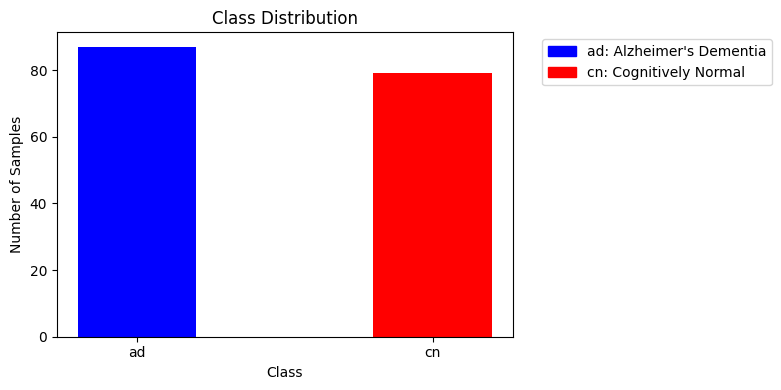

In [ ]:
# count files in each audio directory
ad_count = count_files(str(paths['audio_ad']))
cn_count = count_files(str(paths['audio_cn']))

print(ad_count)
print(cn_count)

# prepare data for plotting
classes = ['ad', 'cn']
counts = [ad_count, cn_count]
colors = ['blue', 'red']

# create bar chart
plt.figure(figsize=(8, 4))
bar_width = 0.4
plt.bar(classes, counts, color=colors, width=bar_width)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')

# create legend
legend_handles = [
    mpatches.Patch(color='blue', label="ad: Alzheimer's Dementia"),
    mpatches.Patch(color='red', label="cn: Cognitively Normal")
]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


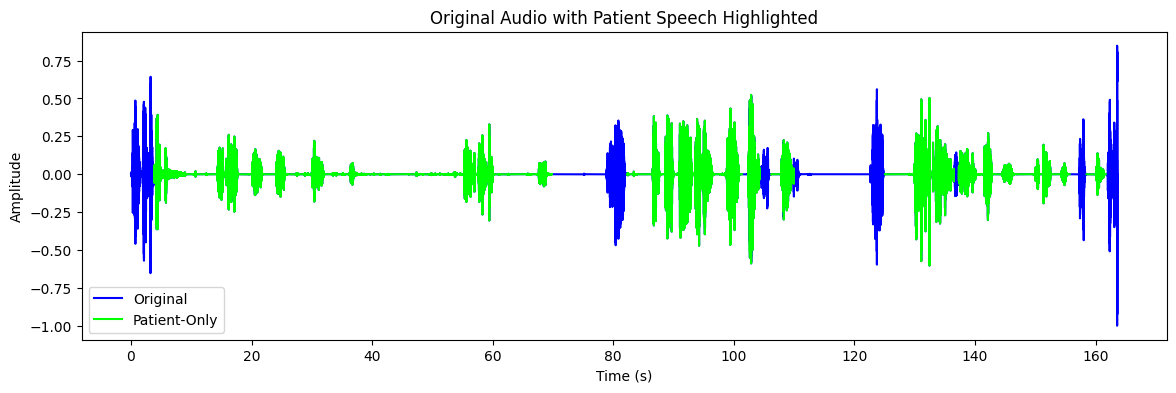

In [ ]:
# retrieve the first .wav file from the 'audio_ad' directory
first_audio_file = next(paths['audio_ad'].glob("*.wav"), None)
if first_audio_file is None:
    raise FileNotFoundError("No audio file found in the specified directory.")

# construct the corresponding segmentation CSV file path
audio_basename = first_audio_file.stem
seg_file = paths['segmentation_ad'] / f"{audio_basename}.csv"

# process the audio file with overlay plot enabled
audio, sr, patient_mask, concatenated, segments = process_audio(first_audio_file, seg_file, plot=True)


### Feature Extraction


In [ ]:
extract_full_audio_features(paths)

In [ ]:
extract_patient_audio_features(paths)

### Training

In [ ]:
perf_results, clf_models = train_and_evaluate()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training and evaluation complete.


In [ ]:
display_results_table(perf_results, clf_models)

| Model              |   Full-Raw |   Full-Std |   Full-Noise |   Patient-Raw |   Patient-Std |   Patient-Noise |
|--------------------|------------|------------|--------------|---------------|---------------|-----------------|
| LogisticRegression |   0.617647 |   0.735294 |     0.705882 |      0.545455 |      0.515152 |        0.515152 |
| DecisionTree       |   0.5      |   0.558824 |     0.529412 |      0.454545 |      0.515152 |        0.424242 |
| RandomForest       |   0.529412 |   0.529412 |     0.5      |      0.575758 |      0.484848 |        0.454545 |
| XGBoost            |   0.588235 |   0.588235 |     0.558824 |      0.484848 |      0.484848 |        0.393939 |
| MLP                |   0.5      |   0.470588 |     0.558824 |      0.545455 |      0.545455 |        0.575758 |


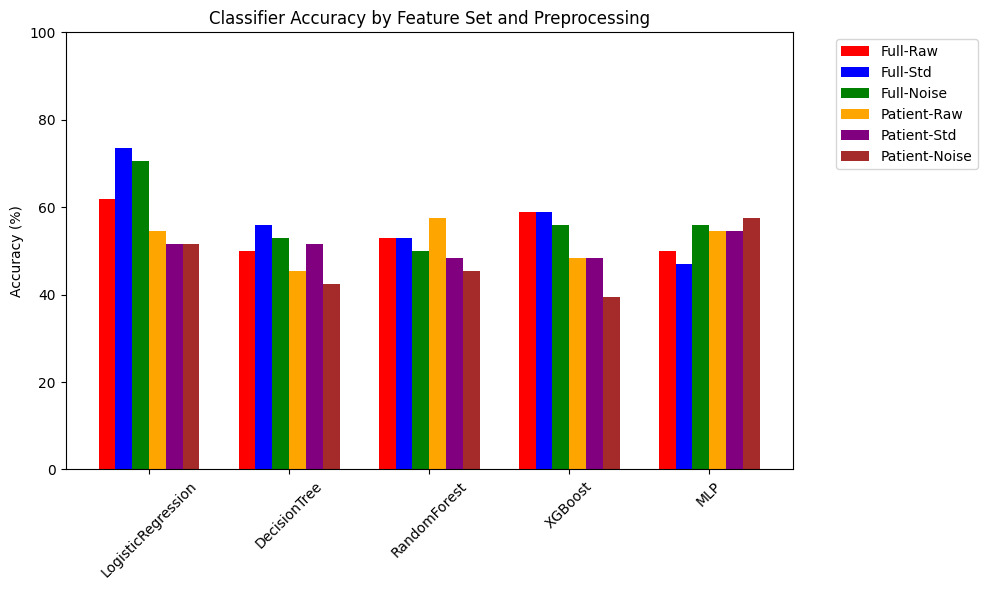

In [ ]:
plot_results(perf_results, clf_models)

### File-wise Feature Extraction

In [ ]:



def extract_segment_features(paths, min_duration_s=0.5):
    feats, labels, file_ids = [], [], []
    for audio_folder, seg_folder, label in [
        (paths['audio_ad'], paths['segmentation_ad'], 1),
        (paths['audio_cn'], paths['segmentation_cn'], 0)
    ]:
        for audio_file in audio_folder.glob("*.wav"):
            audio, sr = load_audio_file(audio_file)
            seg_df = load_segmentation(seg_folder / f"{audio_file.stem}.csv")
            _, _, segments = extract_patient_segments(audio, sr, seg_df)
            for start, end in segments:
                duration = (end - start) / sr
                if duration < min_duration_s:
                    # skip tiny segments
                    continue
                segment_audio = audio[start:end]
                vec = extract_patient_eGeMAPS(segment_audio, sr)
                feats.append(vec)
                labels.append(label)
                file_ids.append(audio_file.stem)
    return np.vstack(feats), np.array(labels), np.array(file_ids)


def compute_averaged_features(feats, labels, file_ids):
    """
    Given segment-level feats/labels/file_ids, average each file's segments
    to one vector. Returns (avg_feats, avg_labels, unique_file_ids).
    """
    avg_feats, avg_labels, unique_ids = [], [], []
    for fid in np.unique(file_ids):
        idx = file_ids == fid
        avg_feats.append(feats[idx].mean(axis=0))
        avg_labels.append(labels[idx][0])
        unique_ids.append(fid)
    return np.vstack(avg_feats), np.array(avg_labels), np.array(unique_ids)



def evaluate_averages(X, y, classifiers, test_size=0.2, random_state=42):
    """
    Split on files, then for each model build a pipeline:
      Imputer → Scaler → Classifier
    Returns accuracy on the file-level averaged features.
    """
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    results = {}
    for name, clf in classifiers.items():
        pipe = make_pipeline(
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            clone(clf)
        )
        pipe.fit(X_tr, y_tr)
        results[name] = pipe.score(X_te, y_te)
    return results


def evaluate_segments_with_majority(feats, labels, file_ids, classifiers,
                                    test_size=0.2, random_state=42):
    """
    1) Split files into train/test (so no segment leakage).
    2) Build a pipeline Imputer→Scaler→Classifier.
    3) Train on all segments from train files.
    4) Predict each segment in test files, then majority‑vote per file.
    5) Return file‑level accuracy.
    """
    # 1) file-level labels
    df_files = pd.DataFrame({'file_id': file_ids, 'label': labels})
    file_df = df_files.drop_duplicates('file_id').reset_index(drop=True)

    # 2) train/test split on file IDs
    train_ids, test_ids = train_test_split(
        file_df['file_id'],
        test_size=test_size,
        stratify=file_df['label'],
        random_state=random_state
    )

    # 3) masks for segments
    train_mask = np.isin(file_ids, train_ids)
    test_mask  = np.isin(file_ids, test_ids)

    results = {}
    for name, clf in classifiers.items():
        pipe = make_pipeline(
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            clone(clf)
        )
        # train on all segments of the train files
        pipe.fit(feats[train_mask], labels[train_mask])

        # predict & vote
        file_preds = {}
        for fid in test_ids:
            idx_file    = np.where(file_ids == fid)[0]
            seg_preds   = pipe.predict(feats[idx_file])
            majority    = Counter(seg_preds).most_common(1)[0][0]
            file_preds[fid] = majority

        true = file_df.set_index('file_id').loc[test_ids, 'label']
        pred = pd.Series(file_preds)
        results[name] = (pred == true).mean()

    return results


#### Extract Everything

In [ ]:
feats_seg, labels_seg, file_ids = extract_segment_features(paths)

/usr/local/lib/python3.11/dist-packages/opensmile/core/smile.py:297: UserWarning: Segment too short, filling with NaN.
  warnings.warn(UserWarning("Segment too short, filling with NaN."))


In [ ]:
# RAW vs STD for averaged features
def evaluate_averages_variant(X, y, classifiers, standardize=False,
                              test_size=0.2, random_state=42):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    results = {}
    for name, clf in classifiers.items():
        steps = [SimpleImputer(strategy="mean")]
        if standardize:
            steps.append(StandardScaler())
        steps.append(clone(clf))
        pipe = make_pipeline(*steps)
        pipe.fit(X_tr, y_tr)
        results[name] = pipe.score(X_te, y_te)
    return results

# RAW vs STD for segment+majority-vote
def evaluate_segments_variant(feats, labels, file_ids, classifiers,
                              standardize=False,
                              test_size=0.2, random_state=42):
    df_files = pd.DataFrame({'file_id': file_ids, 'label': labels})
    file_df = df_files.drop_duplicates('file_id').reset_index(drop=True)
    train_ids, test_ids = train_test_split(
        file_df['file_id'], test_size=test_size,
        stratify=file_df['label'], random_state=random_state
    )
    train_mask = np.isin(file_ids, train_ids)
    results = {}
    for name, clf in classifiers.items():
        steps = [SimpleImputer(strategy="mean")]
        if standardize:
            steps.append(StandardScaler())
        steps.append(clone(clf))
        pipe = make_pipeline(*steps)
        # train on all train segments
        pipe.fit(feats[train_mask], labels[train_mask])

        # predict + vote
        votes = {}
        for fid in test_ids:
            idx = np.where(file_ids == fid)[0]
            pred_segs = pipe.predict(feats[idx])
            votes[fid] = Counter(pred_segs).most_common(1)[0][0]

        true = file_df.set_index('file_id').loc[test_ids, 'label']
        pred = pd.Series(votes)
        results[name] = (pred == true).mean()
    return results


# compute per-file averages
feats_avg, labels_avg, file_ids_avg = compute_averaged_features(
    feats_seg, labels_seg, file_ids
)

# get classifers
classifiers = get_classifiers()

# Averaged
res_avg_raw = evaluate_averages_variant(feats_avg, labels_avg, classifiers, standardize=False)
res_avg_std = evaluate_averages_variant(feats_avg, labels_avg, classifiers, standardize=True)

# Segment+Vote
res_seg_raw = evaluate_segments_variant(feats_seg, labels_seg, file_ids, classifiers, standardize=False)
res_seg_std = evaluate_segments_variant(feats_seg, labels_seg, file_ids, classifiers, standardize=True)

# ── 4) TABULATE COMPARISON ───────────────────────────────────────────────────
from tabulate import tabulate

table = []
for model in classifiers:
    table.append([
        model,
        f"{res_avg_raw[model]:.3f}",
        f"{res_avg_std[model]:.3f}",
        f"{res_seg_raw[model]:.3f}",
        f"{res_seg_std[model]:.3f}",
    ])

print(tabulate(
    table,
    headers=["Model", "Avg‑Raw", "Avg‑Std", "Seg+Vote‑Raw", "Seg+Vote‑Std"],
    tablefmt="github"
))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

| Model              |   Avg‑Raw |   Avg‑Std |   Seg+Vote‑Raw |   Seg+Vote‑Std |
|--------------------|-----------|-----------|----------------|----------------|
| LogisticRegression |     0.636 |     0.636 |          0.667 |          0.576 |
| DecisionTree       |     0.576 |     0.545 |          0.545 |          0.576 |
| RandomForest       |     0.606 |     0.515 |          0.636 |          0.576 |
| XGBoost            |     0.576 |     0.576 |          0.667 |          0.667 |
| MLP                |     0.455 |     0.576 |          0.545 |          0.727 |


### Window-Level Summary Statistics (eGeMAPS)  

Each recording is partitioned into **250 ms windows with 50 % overlap**. For every window we pull the 88 eGeMAPS low-level descriptors. We then ignore the temporal order and, **for all windows belonging to the *same file*,** compute eight simple functionals—mean, std, min, max, 25 %, median, 75 %, skew—per descriptor. Concatenating these 8 × 88 numbers yields a fixed-length **704-dimensional utterance vector**, regardless of how long the conversation lasts.

We benchmark three variants  

1. **Patient-only 704** – compute the statistics using windows where the speaker tag is **PAR** (baseline).  
2. **Patient-only 704, pruned** – start from the baseline vector, then drop the lowest-informative features (e.g., bottom *x* % by ANOVA F-score) before training.  
3. **Full-dialogue 704** – compute the same statistics over **all** speech (patient + doctor) to see if clinician prompts add useful signal.

Every variant is merged with `split_master.csv` and run through the usual Random Forest, XGBoost, and MLP pipeline; accuracy, precision, recall, and F1 indicate which summarisation (and whether pruning or including doctor speech) best distinguishes AD from control.

In [4]:
import os
import tempfile
from pathlib import Path
import numpy as np
import pandas as pd
import soundfile as sf
import opensmile

# extract patient segments
def extract_patient_segments(audio: np.ndarray, sr: int, seg_df: pd.DataFrame, speaker: str = "PAR"):
    patient_df = seg_df[seg_df['speaker'] == speaker]
    segments = []
    for _, row in patient_df.iterrows():
        b = int(float(row['begin']) * sr / 1000)
        e = int(float(row['end'])   * sr / 1000)
        segments.append(audio[b:e])
    if not segments:
        raise ValueError("no patient segments found")
    concatenated = np.concatenate(segments)
    print(f"[extract] {len(segments)} segments → {len(concatenated)/sr:.2f}s of patient audio")
    return concatenated

# sliding-window egemaps feature extraction
def windows_egemaps(df_windows: pd.DataFrame, audio_id: str, sr: int, win_ms=250, overlap=0.5):
    win_len = int(sr * win_ms/1000)
    hop     = int(win_len * (1 - overlap))
    smile   = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    out = []
    for idx, start in enumerate(range(0, len(df_windows)-win_len+1, hop)):
        w = df_windows[start:start+win_len]
        feat = smile.process_signal(w, sr)              # returns 1×88 DataFrame
        feat.insert(0, 'window_idx', idx)
        feat.insert(0, 'file_id', audio_id)
        out.append(feat)
    print(f"[windows] extracted {len(out)} windows of {win_ms} ms")
    return pd.concat(out, ignore_index=True)

# pick first AD file & its seg CSV
base = Path('ADReSSo21/diagnosis/train')
audio_ad = base/'audio'/'ad'
seg_ad   = base/'segmentation'/'ad'

first_wav = next(audio_ad.glob('*.wav'))
file_id   = first_wav.stem
seg_csv   = seg_ad/f"{file_id}.csv"
print(f"Processing {first_wav.name}, seg file: {seg_csv.name}")

# load & extract
audio, sr = sf.read(str(first_wav))
seg_df    = pd.read_csv(seg_csv)
patient   = extract_patient_segments(audio, sr, seg_df, speaker="PAR")

# run windowed eGeMAPS + collect
df_feats = windows_egemaps(patient, file_id, sr, win_ms=250, overlap=0.5)

# inspect & save
print(df_feats.shape)
display(df_feats.head())
df_feats.to_csv(f"{file_id}_egemaps_windows.csv", index=False)
print(f"Saved → {file_id}_egemaps_windows.csv")

Processing adrso055.wav, seg file: adrso055.csv
[extract] 16 segments → 87.98s of patient audio
[windows] extracted 702 windows of 250 ms
(702, 90)


,file_id,window_idx,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,adrso055,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-0.011983,0.003944,0.072984,0.000000,0.000000,0.000,0.000,0.16,0.00,-49.126007
1,adrso055,1,31.011438,0.454100,15.346731,43.569427,43.620182,28.273451,478.351898,0.0,...,-0.023443,0.013276,0.228837,4.166667,10.526316,0.035,0.005,0.03,0.01,-37.647812
2,adrso055,2,48.373631,0.070602,43.619541,50.170635,51.297256,7.677715,129.657684,0.0,...,0.005013,0.024496,0.334682,4.166667,11.111112,0.035,0.015,0.08,0.00,-37.551567
3,adrso055,3,50.658199,0.015797,49.610641,51.144432,51.383301,1.772659,54.428101,0.0,...,0.040846,-0.005421,0.099824,4.166667,10.526316,0.060,0.000,0.02,0.00,-46.567276
4,adrso055,4,51.321331,0.004524,51.107655,51.273418,51.515846,0.408192,0.000000,0.0,...,-0.009598,-0.009368,0.078798,0.000000,5.882353,0.030,0.000,0.12,0.00,-48.095322


Saved → adrso055_egemaps_windows.csv


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

# aggregation function
def compute_aggregated_features(feats, labels, file_ids, mode="mean"):
    """
    feats: 2D array of segment-level features
    labels: 1D array of segment-level labels
    file_ids: 1D array of segment-level file IDs
    mode: "mean", "median", or "2stats"
    """
    agg_feats, agg_labels = [], []
    unique_ids = np.unique(file_ids)
    for fid in unique_ids:
        mask = (file_ids == fid)
        block = feats[mask]
        if mode == "mean":
            vec = block.mean(axis=0)
        elif mode == "median":
            vec = np.median(block, axis=0)
        elif mode == "2stats":
            vec = np.hstack([block.mean(axis=0), np.median(block, axis=0)])
        else:
            raise ValueError(f"Unknown mode: {mode}")
        agg_feats.append(vec)
        # all segments share the same file label
        agg_labels.append(labels[mask][0])
    return np.vstack(agg_feats), np.array(agg_labels)

# evaluator for averaged features
def evaluate_aggregates(X, y, classifiers, standardize=True, test_size=0.2, random_state=42):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    results = {}
    for name, clf in classifiers.items():
        steps = [SimpleImputer(strategy="mean")]
        if standardize:
            steps.append(StandardScaler())
        steps.append(clone(clf))
        pipe = make_pipeline(*steps)
        pipe.fit(X_tr, y_tr)
        results[name] = pipe.score(X_te, y_te)
    return results

# run all aggregation experiments
modes = ["mean", "median", "2stats"]
agg_results = {}

for mode in modes:
    feats_agg, labels_agg = compute_aggregated_features(feats_seg, labels_seg, file_ids, mode=mode)
    agg_results[mode] = evaluate_aggregates(feats_agg, labels_agg, classifiers, standardize=True)

# display comparison table
table = []
for model in classifiers:
    row = [model] + [f"{agg_results[mode][model]:.3f}" for mode in modes]
    table.append(row)

print(tabulate(
    table,
    headers=["Model"] + modes,
    tablefmt="github"
))


| Model              |   mean |   median |   2stats |
|--------------------|--------|----------|----------|
| LogisticRegression |  0.636 |    0.606 |    0.636 |
| DecisionTree       |  0.606 |    0.515 |    0.576 |
| RandomForest       |  0.485 |    0.576 |    0.515 |
| XGBoost            |  0.576 |    0.606 |    0.515 |
| MLP                |  0.667 |    0.667 |    0.545 |


### Window-Level Feature Extraction

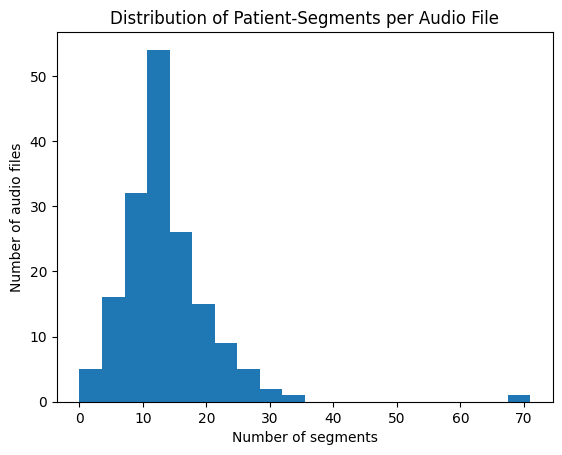

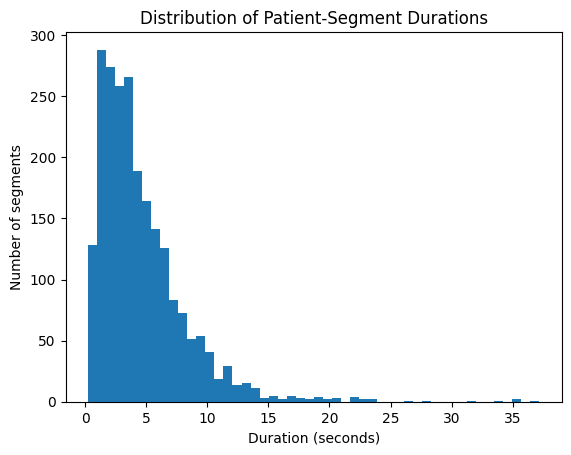

In [ ]:

# 1) Gather segment counts and durations
dataset_dir = Path('ADReSSo21/diagnosis/train')
seg_folders = [dataset_dir/'segmentation'/'ad', dataset_dir/'segmentation'/'cn']

file_counts = []
segment_durations = []  # in seconds

for seg_folder in seg_folders:
    for seg_file in sorted(seg_folder.glob("*.csv")):
        df = pd.read_csv(seg_file)
        df_par = df[df['speaker'] == 'PAR']
        file_counts.append(len(df_par))
        # durations: convert ms to seconds
        segment_durations.extend((df_par['end'] - df_par['begin']) / 1000.0)

# 2) Plot histogram: number of patient segments per file
plt.figure()
plt.hist(file_counts, bins=20)
plt.title("Distribution of Patient-Segments per Audio File")
plt.xlabel("Number of segments")
plt.ylabel("Number of audio files")
plt.show()

# 3) Plot histogram: segment duration distribution
plt.figure()
plt.hist(segment_durations, bins=50)
plt.title("Distribution of Patient-Segment Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of segments")
plt.show()

In [ ]:
np.random.seed(42)


# 1) Paths
BASE = Path('ADReSSo21/diagnosis/train')
paths = {
    'audio_ad':        BASE/'audio'/'ad',
    'audio_cn':        BASE/'audio'/'cn',
    'segmentation_ad': BASE/'segmentation'/'ad',
    'segmentation_cn': BASE/'segmentation'/'cn',
}

# 2) Extract patient segments
def extract_patient_segments(audio, sr, seg_csv):
    df = pd.read_csv(seg_csv)
    segs = []
    for _, r in df[df['speaker']=='PAR'].iterrows():
        start = int(r['begin']*sr/1000)
        end   = int(r['end']  *sr/1000)
        segs.append((start, end))
    return segs

# 3) Slide fixed windows inside those segments
def slide_windows(audio, sr, segments, frame_s=0.25, hop_s=0.05):
    fL = int(frame_s*sr)
    hL = int(hop_s  *sr)
    wins = []
    for (s,e) in segments:
        if e-s < fL: continue
        for i in range(s, e-fL+1, hL):
            wins.append(audio[i:i+fL])
    return wins

# 4) Extract eGeMAPS per window, cap per file
def extract_window_features(paths,
                            frame_s: float = 0.25,
                            hop_s: float = 0.05,
                            max_windows_per_file: int = 200):

    # initialize openSMILE (eGeMAPSv02 functionals)
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    feats, labs, fids = [], [], []

    for audio_folder, seg_folder, label in [
        (paths['audio_ad'],        paths['segmentation_ad'], 1),
        (paths['audio_cn'],        paths['segmentation_cn'], 0)
    ]:
        for wav_path in audio_folder.glob("*.wav"):
            # 1) load full audio
            audio, sr = sf.read(wav_path)

            # 2) load segmentation DataFrame
            seg_csv = seg_folder / f"{wav_path.stem}.csv"
            df = pd.read_csv(seg_csv)
            # filter only patient turns
            patient_rows = df[df['speaker'] == 'PAR']

            # 3) slice out segments
            segments = []
            for _, row in patient_rows.iterrows():
                start = int(row['begin'] * sr / 1000)
                end   = int(row['end']   * sr / 1000)
                segments.append((start, end))

            # 4) slide windows within each segment
            frame_len = int(frame_s * sr)
            hop_len   = int(hop_s   * sr)
            windows   = []
            for (s, e) in segments:
                if e - s < frame_len:
                    continue
                for i in range(s, e - frame_len + 1, hop_len):
                    windows.append(audio[i : i + frame_len])

            # 5) down-sample if too many windows
            if len(windows) > max_windows_per_file:
                np.random.seed(42)
                idxs = np.random.choice(len(windows), max_windows_per_file, replace=False)
                windows = [windows[i] for i in idxs]

            # 6) extract eGeMAPS per window via temp WAV + process_file
            for win in windows:
                with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
                    tmp_name = tmp.name
                sf.write(tmp_name, win, sr)
                feats_df = smile.process_file(tmp_name)
                os.remove(tmp_name)

                feats.append(feats_df.values.flatten())
                labs.append(label)
                fids.append(wav_path.stem)

    # stack into arrays
    feats = np.vstack(feats)
    labs  = np.array(labs)
    fids  = np.array(fids)

    return feats, labs, fids


# 5) Aggregate to file level
def aggregate(feats, labs, fids, mode='mean'):
    X, y = [], []
    for fid in np.unique(fids):
        block = feats[fids==fid]
        vec = block.mean(axis=0) if mode=='mean' else np.median(block,axis=0)
        X.append(vec); y.append(labs[fids==fid][0])
    return np.vstack(X), np.array(y)

# 6) Evaluators
def eval_agg(X,y,clfs):
    Xtr,Xte,ytr,yte = train_test_split(X,y, stratify=y, test_size=0.2, random_state=42)
    res = {}
    for n,clf in clfs.items():
        pipe = make_pipeline(SimpleImputer('mean'), StandardScaler(), clone(clf))
        pipe.fit(Xtr,ytr)
        res[n] = pipe.score(Xte,yte)
    return res

def eval_vote(feats, labs, fids, clfs):
    df = pd.DataFrame({'fid':fids,'lab':labs})
    files = df.drop_duplicates('fid').reset_index(drop=True)
    train_ids, test_ids = train_test_split(files['fid'], stratify=files['lab'],
                                           test_size=0.2, random_state=42)
    mask = np.isin(fids, train_ids)
    res = {}
    for n,clf in clfs.items():
        pipe = make_pipeline(SimpleImputer('mean'), StandardScaler(), clone(clf))
        pipe.fit(feats[mask], labs[mask])
        votes = {}
        for fid in test_ids:
            idx = np.where(fids==fid)[0]
            p = pipe.predict(feats[idx])
            votes[fid] = Counter(p).most_common(1)[0][0]
        true = files.set_index('fid').loc[test_ids,'lab']
        pred = pd.Series(votes)
        res[n] = (pred==true).mean()
    return res

In [ ]:
# 7) Run it
feats_win, labs_win, fids_win = extract_window_features(paths)
clfs = get_classifiers()   # your existing model dict

# 7a) window-mean
Xw, yw = aggregate(feats_win, labs_win, fids_win, mode='mean')
r_mean = eval_agg(Xw, yw, clfs)

# 7b) window+vote
r_vote = eval_vote(feats_win, labs_win, fids_win, clfs)

# 8) Show comparison
table = [[m, f"{r_mean[m]:.3f}", f"{r_vote[m]:.3f}"] for m in clfs]
print(tabulate(table, headers=["Model","Win-Mean","Win+Vote"], tablefmt="github"))


In [ ]:
np.savez(
    "window_features.npz",
    feats=feats_win,
    labels=labs_win,
    file_ids=fids_win
)

In [ ]:
# 1) Load saved window‐level arrays
data = np.load("window_features.npz", allow_pickle=True)
feats_win = data["feats"]
labs_win  = data["labels"]
fids_win  = data["file_ids"]

# 2) Define aggregation and evaluators
def aggregate(feats, labs, fids, mode='mean'):
    X, y = [], []
    for fid in np.unique(fids):
        block = feats[fids == fid]
        vec = block.mean(axis=0) if mode=='mean' else np.median(block, axis=0)
        X.append(vec)
        y.append(labs[fids == fid][0])
    return np.vstack(X), np.array(y)

def eval_agg(X, y, clfs, test_size=0.2, random_state=42):
    Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y,
                                          test_size=test_size,
                                          random_state=random_state)
    res = {}
    for name, clf in clfs.items():
        pipe = make_pipeline(
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            clone(clf)
        )
        pipe.fit(Xtr, ytr)
        res[name] = pipe.score(Xte, yte)
    return res

def eval_vote(feats, labs, fids, clfs, test_size=0.2, random_state=42):
    df = pd.DataFrame({'file_id': fids, 'label': labs})
    files = df.drop_duplicates('file_id').reset_index(drop=True)
    train_ids, test_ids = train_test_split(
        files['file_id'], stratify=files['label'],
        test_size=test_size, random_state=random_state
    )
    mask = np.isin(fids, train_ids)
    res = {}
    for name, clf in clfs.items():
        pipe = make_pipeline(
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            clone(clf)
        )
        pipe.fit(feats[mask], labs[mask])
        votes = {}
        for fid in test_ids:
            idxs = np.where(fids == fid)[0]
            preds = pipe.predict(feats[idxs])
            votes[fid] = Counter(preds).most_common(1)[0][0]
        true = files.set_index('file_id').loc[test_ids, 'label']
        pred = pd.Series(votes)
        res[name] = (pred == true).mean()
    return res

# 3) Load or define your classifiers
clfs = get_classifiers()   # same as before

# 4) Run just the evaluations
# 4a) Window‐mean aggregated features
Xw, yw = aggregate(feats_win, labs_win, fids_win, mode='mean')
res_mean = eval_agg(Xw, yw, clfs)

# 4b) Window+majority‐vote
res_vote = eval_vote(feats_win, labs_win, fids_win, clfs)

# 5) Display results
table = [[m, f"{res_mean[m]:.3f}", f"{res_vote[m]:.3f}"] for m in clfs]
print(tabulate(table, headers=["Model","Win-Mean","Win+Vote"], tablefmt="github"))

| Model              |   Win-Mean |   Win+Vote |
|--------------------|------------|------------|
| LogisticRegression |      0.606 |      0.606 |
| DecisionTree       |      0.485 |      0.576 |
| RandomForest       |      0.667 |      0.636 |
| XGBoost            |      0.545 |      0.636 |
| MLP                |      0.485 |      0.667 |


In [ ]:
# --- 1) Drop any windows (rows) with NaNs ---
mask_samples = ~np.any(np.isnan(feats_win), axis=1)
feats_clean  = feats_win[mask_samples]
labs_clean   = labs_win[mask_samples]
fids_clean   = fids_win[mask_samples]
print(f"Dropped {len(feats_win) - len(feats_clean)} windows containing NaNs")

# --- 2) (Optional) Drop features (columns) with NaNs across remaining windows ---
mask_features = ~np.any(np.isnan(feats_clean), axis=0)
feats_clean   = feats_clean[:, mask_features]
print(f"Dropped {feats_win.shape[1] - feats_clean.shape[1]} features containing NaNs")

# --- 3) Scale the cleaned features ---
scaler = StandardScaler()
feats_scaled = scaler.fit_transform(feats_clean)

# --- 4) Verify zero‐mean/unit‐variance ---
print("First 5 means (≈0):", np.round(feats_scaled.mean(axis=0)[:5], 5))
print("First 5 stds  (≈1):", np.round(feats_scaled.std(axis=0)[:5], 5))

# --- 5) Re‑evaluate on cleaned + scaled windows ---
#   5a) Window‑mean aggregation
Xw_scaled, yw_scaled = aggregate(feats_scaled, labs_clean, fids_clean, mode='mean')
res_mean_clean_scaled = eval_agg(Xw_scaled, yw_scaled, clfs)

#   5b) Window+majority‑vote
res_vote_clean_scaled = eval_vote(feats_scaled, labs_clean, fids_clean, clfs)

# --- 6) Display results ---
table = []
for model in clfs:
    table.append([
        model,
        f"{res_mean_clean_scaled[model]:.3f}",
        f"{res_vote_clean_scaled[model]:.3f}"
    ])
print(tabulate(
    table,
    headers=["Model", "Win‑Mean (Clean+Scaled)", "Win+Vote (Clean+Scaled)"],
    tablefmt="github"
))


Dropped 29 windows containing NaNs
Dropped 0 features containing NaNs
First 5 means (≈0): [ 0.  0. -0. -0. -0.]
First 5 stds  (≈1): [1. 1. 1. 1. 1.]
| Model              |   Win‑Mean (Clean+Scaled) |   Win+Vote (Clean+Scaled) |
|--------------------|---------------------------|---------------------------|
| LogisticRegression |                     0.576 |                     0.606 |
| DecisionTree       |                     0.606 |                     0.515 |
| RandomForest       |                     0.485 |                     0.606 |
| XGBoost            |                     0.636 |                     0.667 |
| MLP                |                     0.485 |                     0.636 |


#### Grid Search

In [ ]:
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


# --- 0) Load precomputed file‑level aggregated features ---
# Assumes you've already saved window_features.npz and aggregated via 'aggregate'
data = np.load("window_features.npz", allow_pickle=True)
feats_win = data["feats"]
labs_win  = data["labels"]
fids_win  = data["file_ids"]

# Drop any windows with NaNs (just in case)
mask = ~np.any(np.isnan(feats_win), axis=1)
feats_win = feats_win[mask]
labs_win  = labs_win[mask]
fids_win  = fids_win[mask]

# Build file‑level mean aggregation
from collections import Counter
def aggregate(feats, labs, fids, mode='mean'):
    X, y = [], []
    for fid in np.unique(fids):
        block = feats[fids == fid]
        vec = block.mean(axis=0) if mode=='mean' else np.median(block, axis=0)
        X.append(vec)
        y.append(labs[fids == fid][0])
    return np.vstack(X), np.array(y)

Xw, yw = aggregate(feats_win, labs_win, fids_win, mode='mean')

# --- 1) Pipeline + RandomForest ---
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42))
])

# --- 2) Hyperparameter distributions ---
param_dist = {
    "rf__n_estimators": randint(100, 500),
    "rf__max_depth": [None] + list(range(10, 101, 10)),
    "rf__min_samples_split": randint(2, 11),
    "rf__min_samples_leaf": randint(1, 5),
    "rf__max_features": ["sqrt", "log2", None]
}

# --- 3) RandomizedSearchCV setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring="accuracy",
    random_state=42,
    n_jobs=12,
    verbose=2
)

# --- 4) Fit and report ---
rs.fit(Xw, yw)
print("Best RF params:", rs.best_params_)
print("Best CV accuracy: {:.3f}".format(rs.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'rf__max_depth': 90, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 191}
Best CV accuracy: 0.578


In [ ]:
# Cell 2: imports & paths
import os
from pathlib import Path
import tempfile
import numpy as np
import pandas as pd
import soundfile as sf
import opensmile
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

BASE = Path("ADReSSo21/diagnosis/train")
paths = {
    "audio_ad": BASE/"audio"/"ad",
    "audio_cn": BASE/"audio"/"cn",
    "seg_ad":   BASE/"segmentation"/"ad",
    "seg_cn":   BASE/"segmentation"/"cn",
}


In [ ]:
# revised parallel extraction helpers (no lambda)
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
import os, tempfile
import numpy as np, pandas as pd, soundfile as sf, opensmile
from pathlib import Path

def _proc_full(wav_path):
    wav = Path(wav_path)
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals
    )
    df = smile.process_file(str(wav))
    return wav.stem, df.values.flatten()

def extract_full_parallel(folder, label, n_jobs=12):
    files = list(Path(folder).glob("*.wav"))
    with ProcessPoolExecutor(max_workers=n_jobs) as exe:
        results = exe.map(_proc_full, files)
    names, feats = zip(*results)
    df = pd.DataFrame(feats, index=names)
    df["label"] = label
    return df

def _proc_pat(wav_path, seg_folder):
    wav = Path(wav_path)
    audio, sr = sf.read(wav)
    seg = pd.read_csv(Path(seg_folder)/f"{wav.stem}.csv")
    masks = [ audio[int(r.begin*sr/1000):int(r.end*sr/1000)]
              for _,r in seg[seg.speaker=="PAR"].iterrows() ]
    if not masks:
        return None
    concat = np.concatenate(masks)
    tf = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
    sf.write(tf.name, concat, sr)
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals
    )
    df = smile.process_file(tf.name)
    tf.close(); os.remove(tf.name)
    return wav.stem, df.values.flatten()

def extract_patient_parallel(audio_folder, seg_folder, label, n_jobs=12):
    files = list(Path(audio_folder).glob("*.wav"))
    with ProcessPoolExecutor(max_workers=n_jobs) as exe:
        results = exe.map(_proc_pat, files, repeat(seg_folder))
    results = [r for r in results if r]
    names, feats = zip(*results)
    df = pd.DataFrame(feats, index=names)
    df["label"] = label
    return df


In [ ]:
# Cell 4: run extraction in parallel, save CSV + .npy
# assume `paths` from Cell 2

# full‑audio
df_full_ad = extract_full_parallel(paths["audio_ad"], 1, n_jobs=12)
df_full_cn = extract_full_parallel(paths["audio_cn"], 0, n_jobs=12)
df_full    = pd.concat([df_full_ad, df_full_cn])
df_full.to_csv("egemaps_full.csv", index_label="file")
Xf = df_full.drop("label", axis=1).values
yf = df_full["label"].values
np.save("egemaps_full.npy", Xf)
np.save("labels_full.npy", yf)

# patient‑only
df_pat_ad = extract_patient_parallel(paths["audio_ad"], paths["seg_ad"], 1, n_jobs=12)
df_pat_cn = extract_patient_parallel(paths["audio_cn"], paths["seg_cn"], 0, n_jobs=12)
df_pat    = pd.concat([df_pat_ad, df_pat_cn])
df_pat.to_csv("egemaps_patient.csv", index_label="file")
Xp = df_pat.drop("label", axis=1).values
yp = df_pat["label"].values
np.save("egemaps_patient.npy", Xp)
np.save("labels_patient.npy", yp)


In [ ]:
# Cell 5: load CSV + train & evaluate RF
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt

# load from CSV
df_full = pd.read_csv("egemaps_full.csv", index_col="file")
Xf = df_full.drop("label", axis=1).values
yf = df_full["label"].values

df_pat = pd.read_csv("egemaps_patient.csv", index_col="file")
Xp = df_pat.drop("label", axis=1).values
yp = df_pat["label"].values

# split & train
Xf_tr, Xf_te, yf_tr, yf_te = train_test_split(Xf, yf, test_size=0.2, stratify=yf, random_state=42)
Xp_tr, Xp_te, yp_tr, yp_te = train_test_split(Xp, yp, test_size=0.2, stratify=yp, random_state=42)

rf_full = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(Xf_tr, yf_tr)
rf_pat  = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(Xp_tr, yp_tr)

# eval
yf_pred = rf_full.predict(Xf_te)
print("Full‑Audio RF")
print("Acc:", accuracy_score(yf_te, yf_pred))
print(classification_report(yf_te, yf_pred))

yp_pred = rf_pat.predict(Xp_te)
print("Patient‑Only RF")
print("Acc:", accuracy_score(yp_te, yp_pred))
print(classification_report(yp_te, yp_pred))

Full‑Audio RF
Acc: 0.4411764705882353
              precision    recall  f1-score   support

           0       0.33      0.19      0.24        16
           1       0.48      0.67      0.56        18

    accuracy                           0.44        34
   macro avg       0.41      0.43      0.40        34
weighted avg       0.41      0.44      0.41        34

Patient‑Only RF
Acc: 0.5454545454545454
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        15
           1       0.57      0.67      0.62        18

    accuracy                           0.55        33
   macro avg       0.54      0.53      0.53        33
weighted avg       0.54      0.55      0.54        33



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt

# load CSVs
df_full = pd.read_csv("egemaps_full.csv", index_col="file")
Xf, yf = df_full.drop("label", axis=1).values, df_full["label"].values
df_pat = pd.read_csv("egemaps_patient.csv", index_col="file")
Xp, yp = df_pat.drop("label", axis=1).values, df_pat["label"].values

# split
Xf_tr, Xf_te, yf_tr, yf_te = train_test_split(Xf, yf, test_size=0.2, stratify=yf, random_state=42)
Xp_tr, Xp_te, yp_tr, yp_te = train_test_split(Xp, yp, test_size=0.2, stratify=yp, random_state=42)

# grid search setup
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# search Full‑Audio
rs_full = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist, n_iter=20, cv=cv,
    scoring="accuracy", n_jobs=-1, random_state=42, verbose=1
)
rs_full.fit(Xf_tr, yf_tr)
best_full = rs_full.best_estimator_
print("Full‑Audio best params:", rs_full.best_params_)
yf_pred = best_full.predict(Xf_te)
print("Full‑Audio test acc:", accuracy_score(yf_te, yf_pred))
print(classification_report(yf_te, yf_pred))

# search Patient‑Only
rs_pat = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist, n_iter=20, cv=cv,
    scoring="accuracy", n_jobs=-1, random_state=42, verbose=1
)
rs_pat.fit(Xp_tr, yp_tr)
best_pat = rs_pat.best_estimator_
print("Patient‑Only best params:", rs_pat.best_params_)
yp_pred = best_pat.predict(Xp_te)
print("Patient‑Only test acc:", accuracy_score(yp_te, yp_pred))
print(classification_report(yp_te, yp_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Full‑Audio best params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Full‑Audio test acc: 0.5294117647058824
              precision    recall  f1-score   support

           0       0.50      0.31      0.38        16
           1       0.54      0.72      0.62        18

    accuracy                           0.53        34
   macro avg       0.52      0.52      0.50        34
weighted avg       0.52      0.53      0.51        34

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Patient‑Only best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}
Patient‑Only test acc: 0.6060606060606061
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.63      0.67      0.65        18

    accuracy                      

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# full‐audio
xgb_full = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                             random_state=42, n_jobs=-1)
lgb_full = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

xgb_full.fit(Xf_tr, yf_tr)
lgb_full.fit(Xf_tr, yf_tr)

y_xgb_full = xgb_full.predict(Xf_te)
y_lgb_full = lgb_full.predict(Xf_te)

print("XGBoost Full‑Audio")
print("Acc:", accuracy_score(yf_te, y_xgb_full))
print(classification_report(yf_te, y_xgb_full))

print("LightGBM Full‑Audio")
print("Acc:", accuracy_score(yf_te, y_lgb_full))
print(classification_report(yf_te, y_lgb_full))

# patient‐only
xgb_pat = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                            random_state=42, n_jobs=-1)
lgb_pat = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

xgb_pat.fit(Xp_tr, yp_tr)
lgb_pat.fit(Xp_tr, yp_tr)

y_xgb_pat = xgb_pat.predict(Xp_te)
y_lgb_pat = lgb_pat.predict(Xp_te)

print("XGBoost Patient‑Only")
print("Acc:", accuracy_score(yp_te, y_xgb_pat))
print(classification_report(yp_te, y_xgb_pat))

print("LightGBM Patient‑Only")
print("Acc:", accuracy_score(yp_te, y_lgb_pat))
print(classification_report(yp_te, y_lgb_pat))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:56:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:56:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 69, number of negative: 63
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3979
[LightGBM] [Info] Number of data points in the train set: 132, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.522727 -> initscore=0.090972
[LightGBM] [Info] Start training from score 0.090972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### wav2vec 2.0 Embeddings

In this section we establish an audio-only baseline using **`facebook/wav2vec2-base-960h`**. Every recording is resampled to 16 kHz, fed through the model, and mean-pooled to a fixed 768-dimensional vector. We benchmark three scenarios:

1. **Full-file embeddings** – entire conversation.  
2. **Patient-only embeddings** – segments labelled **PAR** in the segmentation CSVs.  
3. **Patient-only + z-score normalisation** – same as (2) but each feature is standardised across the dataset.

Each variant is merged with `split_master.csv` and evaluated with Random Forest, XGBoost, and an MLP. Accuracy, precision, recall, and F1 let us see which representation carries the most diagnostic signal.

In [ ]:

# 1) load processor & distilled model
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model     = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").eval().to(device)


TARGET_SR = processor.feature_extractor.sampling_rate  # 16000

# 2) helper: resample + extract 768-D mean-pooled embedding
def extract_w2v2(audio: np.ndarray, sr: int) -> np.ndarray:
    if sr != TARGET_SR:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SR)
        sr = TARGET_SR
    inputs = processor(audio, sampling_rate=sr,
                       return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        hidden = model(**inputs).last_hidden_state  # (1, T, 768)
    return hidden.mean(dim=1).squeeze(0).cpu().numpy()

# 3) extract from **entire** audio files with a progress bar
BASE     = Path("ADReSSo21/diagnosis/train")
audio_ad = BASE/"audio"/"ad"
audio_cn = BASE/"audio"/"cn"

records = []
for folder, label in [(audio_ad, 1), (audio_cn, 0)]:
    wav_files = sorted(folder.glob("*.wav"))
    for wav_path in tqdm(wav_files, desc=f"Processing {folder.name}", unit="file"):
        # load full waveform at original sampling rate
        audio, sr = librosa.load(str(wav_path), sr=None)
        vec = extract_w2v2(audio, sr)
        row = {"file_id": wav_path.stem, "label": label}
        row.update({f"f{i}": float(vec[i]) for i in range(vec.shape[0])})
        records.append(row)

df_feats = pd.DataFrame(records)
df_feats.to_csv("audio_w2v2_full_feats.csv", index=False)
print("saved audio_w2v2_full_feats.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Processing cn: 100%|██████████| 79/79 [00:10<00:00,  7.65file/s]


saved audio_w2v2_full_feats.csv


In [ ]:
# 1) reload the features CSV
df_feats = pd.read_csv("audio_w2v2_full_feats.csv")

# 2) reload the split file
split    = pd.read_csv("split_master.csv")  # columns: file_id | label | split

# 3) merge
df = df_feats.merge(split, on=["file_id", "label"])

# 4) select only the true feature columns (f followed by digits)
feat_cols = [c for c in df.columns if re.fullmatch(r"f\d+", c)]

print(f"Using {len(feat_cols)} feature columns")

# 5) call train_fn on RandomForest, XGBoost, and MLP
results = train_fn(
    df,
    feat_cols,
    split_col="split",
    train_value="train",
    test_value="test",
    models=["rf", "xgb", "mlp"],
    rf_params={"n_estimators":100, "random_state":42},
    xgb_params={"n_estimators":100, "max_depth":4, "learning_rate":0.05, "random_state":42},
    mlp_params={"hidden_layer_sizes":(100,), "max_iter":300, "random_state":42}
)

# 6) display the results in a pretty table
format_results(results)


Using 768 feature columns


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:28:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+--------------+----------+-----------+--------+----------+
|    Model     | Accuracy | Precision | Recall | F1-score |
+--------------+----------+-----------+--------+----------+
| RandomForest |  0.588   |   0.611   | 0.611  |  0.611   |
|   XGBoost    |  0.647   |   0.750   | 0.500  |  0.600   |
|     MLP      |  0.588   |   0.625   | 0.556  |  0.588   |
+--------------+----------+-----------+--------+----------+


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# 1) load model + processor
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model     = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h") \
                         .to(device).eval()
TARGET_SR = processor.feature_extractor.sampling_rate  # 16000


# 4) iterate your dataset, extract patient-only clips & embed
BASE     = Path("ADReSSo21/diagnosis/train")
audio_ad = BASE/"audio"/"ad";    seg_ad = BASE/"segmentation"/"ad"
audio_cn = BASE/"audio"/"cn";    seg_cn = BASE/"segmentation"/"cn"

records = []
for folder, seg_folder, label in [(audio_ad, seg_ad, 1), (audio_cn, seg_cn, 0)]:
    for wav_path in tqdm(sorted(folder.glob("*.wav")), desc=f"Processing {folder.name}", unit="file"):
        # load full waveform
        audio, sr = sf.read(wav_path)
        # load segmentation
        seg_df = pd.read_csv(seg_folder / f"{wav_path.stem}.csv")
        # extract patient speech
        concat = extract_patient_segments(audio, sr, seg_df)
        if concat.size == 0:
            continue
        # get embedding (full length)
        vec = get_w2v2_embedding(concat, sr)
        # record
        row = {"file_id": wav_path.stem, "label": label}
        row.update({f"f{i}": float(vec[i]) for i in range(vec.shape[0])})
        records.append(row)

# 5) save to CSV
df = pd.DataFrame(records)
df.to_csv("audio_w2v2_patient_feats.csv", index=False)


Processing cn: 100%|██████████| 79/79 [00:13<00:00,  5.70file/s]


In [ ]:
# 1) load patient-only wav2vec2 features
df_feats = pd.read_csv("audio_w2v2_patient_feats.csv")

# 2) load canonical split
split    = pd.read_csv("split_master.csv")  # file_id | label | split

# 3) merge on file_id & label
df = df_feats.merge(split, on=["file_id", "label"])

# 4) select feature columns (f followed by digits)
feat_cols = [c for c in df.columns if re.fullmatch(r"f\d+", c)]

print(f"Using {len(feat_cols)} feature columns")

# 5) train all three models
results = train_fn(
    df,
    feat_cols,
    split_col="split",
    train_value="train",
    test_value="test",
    models=["rf", "xgb", "mlp"],
    rf_params={"n_estimators":100, "random_state":42},
    xgb_params={"n_estimators":100, "max_depth":4, "learning_rate":0.05, "random_state":42},
    mlp_params={"hidden_layer_sizes":(100,), "max_iter":300, "random_state":42}
)

# 6) display results
format_results(results)


Using 768 feature columns


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:39:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+--------------+----------+-----------+--------+----------+
|    Model     | Accuracy | Precision | Recall | F1-score |
+--------------+----------+-----------+--------+----------+
| RandomForest |  0.606   |   0.632   | 0.667  |  0.649   |
|   XGBoost    |  0.667   |   0.684   | 0.722  |  0.703   |
|     MLP      |  0.576   |   0.611   | 0.611  |  0.611   |
+--------------+----------+-----------+--------+----------+


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# 1) load patient-only wav2vec2 features
df_feats = pd.read_csv("audio_w2v2_patient_feats.csv")

# 2) load canonical split
split    = pd.read_csv("split_master.csv")  # file_id | label | split

# 3) merge on file_id & label
df = df_feats.merge(split, on=["file_id", "label"])

# 4) select feature columns (f followed by digits)
feat_cols = [c for c in df.columns if re.fullmatch(r"f\d+", c)]
print(f"Using {len(feat_cols)} feature columns")

# 5) normalize all feature columns (zero-mean, unit-variance)
scaler = StandardScaler()
df[feat_cols] = scaler.fit_transform(df[feat_cols])

# 6) train all three models on normalized features
results_norm = train_fn(
    df,
    feat_cols,
    split_col="split",
    train_value="train",
    test_value="test",
    models=["rf", "xgb", "mlp"],
    rf_params={"n_estimators":100, "random_state":42},
    xgb_params={"n_estimators":100, "max_depth":4, "learning_rate":0.05, "random_state":42},
    mlp_params={"hidden_layer_sizes":(100,), "max_iter":300, "random_state":42}
)

# 7) display normalized results
format_results(results_norm)

Using 768 feature columns


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+--------------+----------+-----------+--------+----------+
|    Model     | Accuracy | Precision | Recall | F1-score |
+--------------+----------+-----------+--------+----------+
| RandomForest |  0.606   |   0.632   | 0.667  |  0.649   |
|   XGBoost    |  0.667   |   0.684   | 0.722  |  0.703   |
|     MLP      |  0.606   |   0.647   | 0.611  |  0.629   |
+--------------+----------+-----------+--------+----------+
